# Import Dependensi dan Variabel

In [1474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [1475]:
from variabel import variabel as var

# Import Data

In [1476]:
df_gravimetri = pd.read_csv('hasil/ET Aktual Gravimetri.csv')
df_bc = pd.read_csv('hasil/Estimasi ET Blaney-Criddle.csv')
df_hs = pd.read_csv('hasil/Estimasi ET Hargreaves-Samani.csv')
df_pm = pd.read_csv('hasil/Estimasi ET Penman-Monteith.csv')

# Heatmap Data

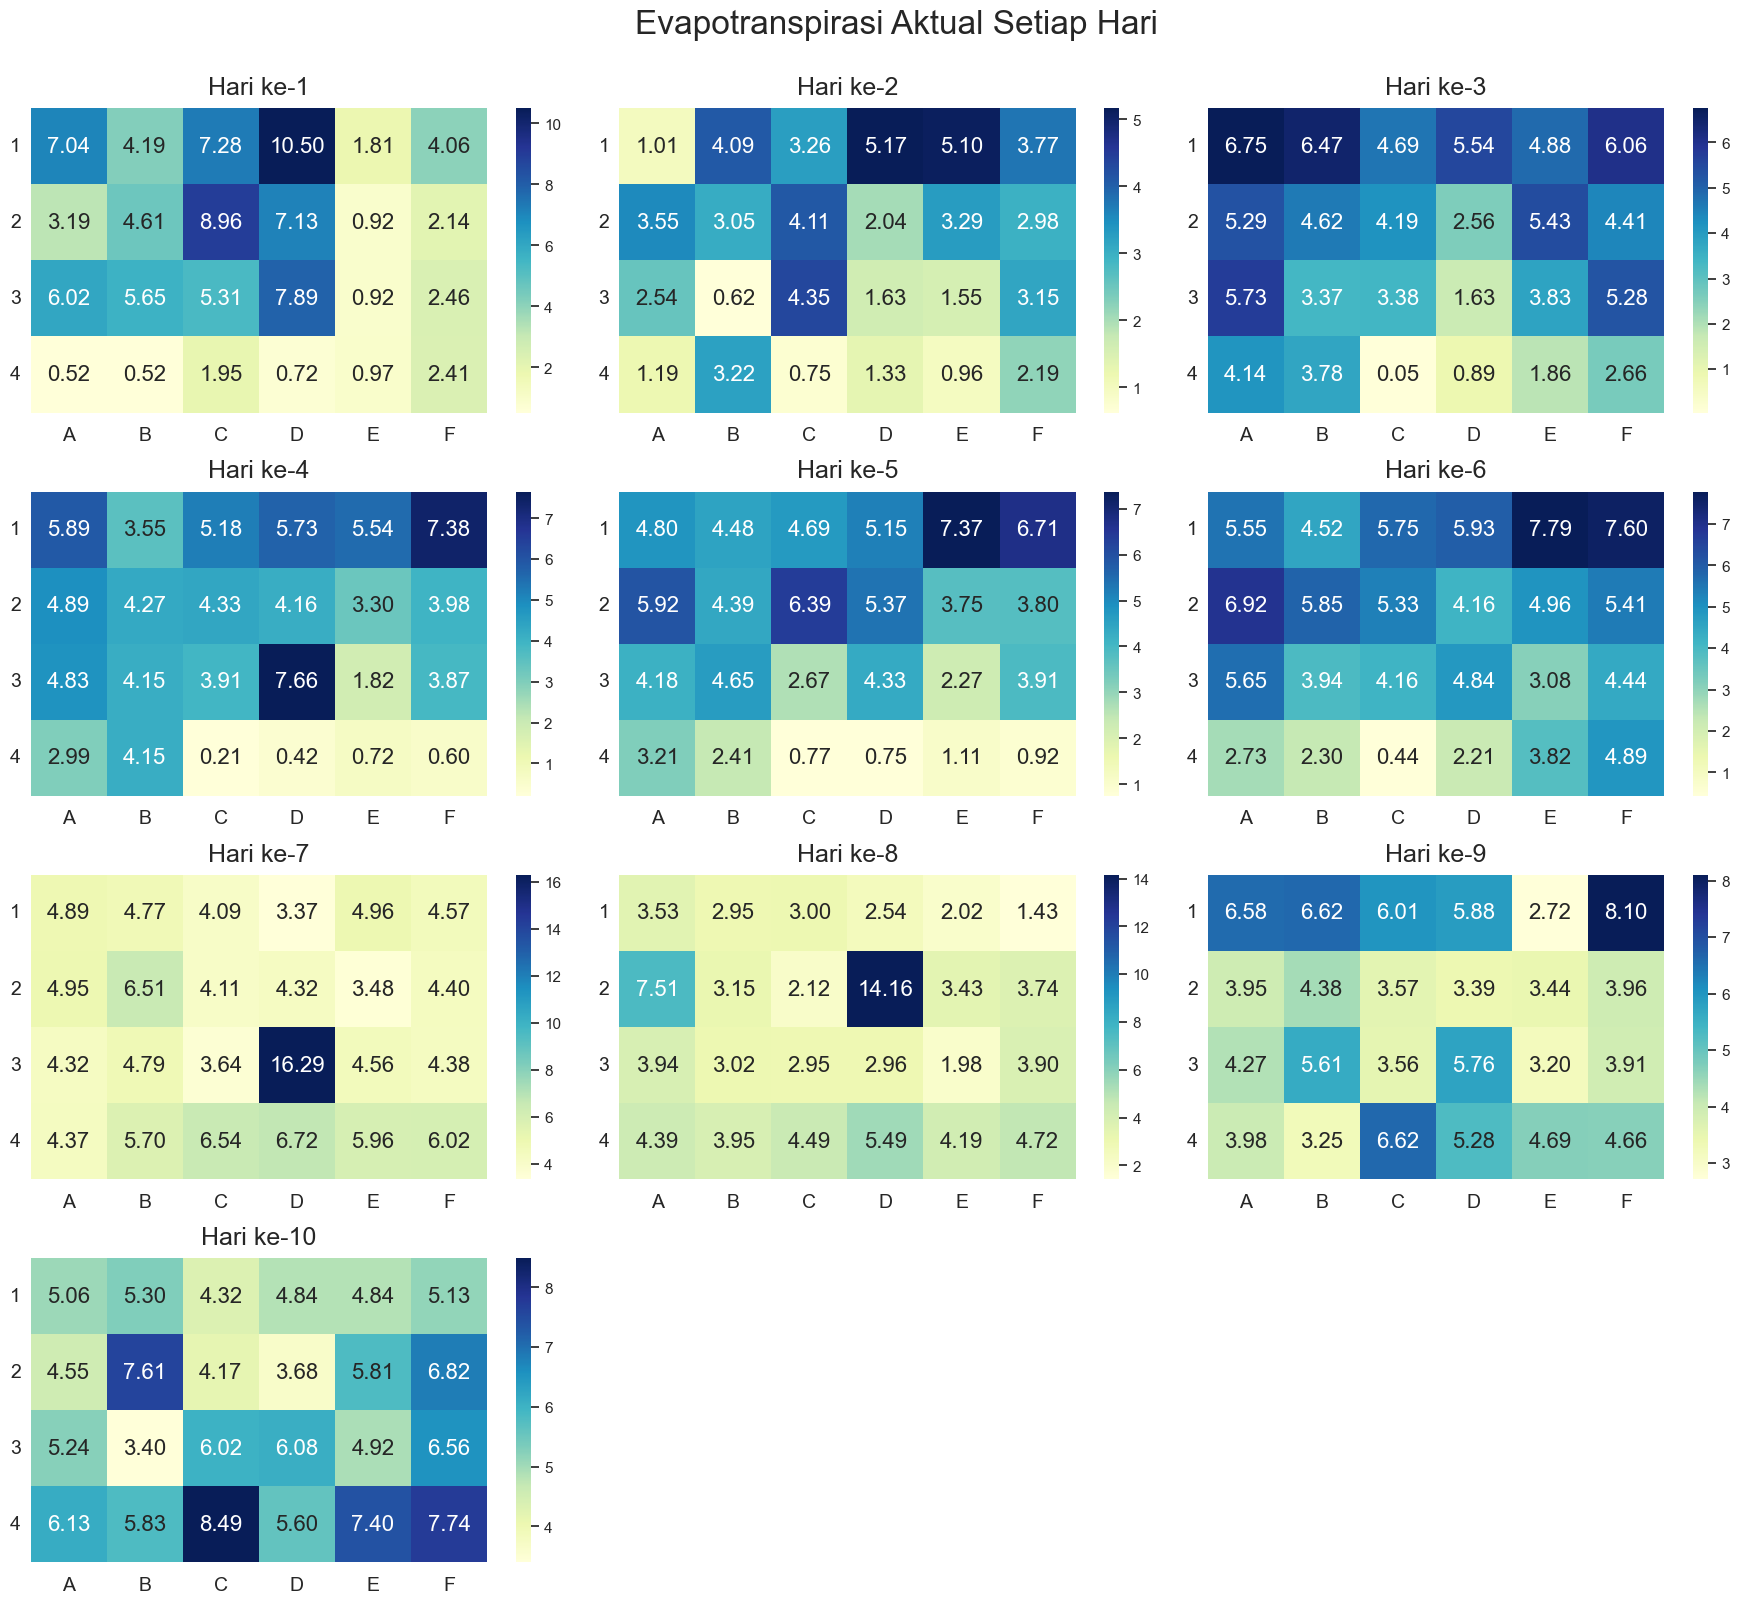

In [1477]:
df_gravimetri.set_index('Num Day', inplace=True)

# Plot heatmaps
fig, axes = plt.subplots(4, 3, figsize=(18, 16))  # 4x3 grid
axes = axes.flatten()

for i, (day, data) in enumerate(df_gravimetri.iterrows()):
    # Reshape data untuk heatmap
    day_data = data.values.reshape(4, 6)  # Reshape ke (4x6)
    
    # Plot heatmap
    sns.heatmap(
        day_data, annot=True, fmt=".2f", cmap="YlGnBu",
        xticklabels=[], yticklabels=[],
        annot_kws={"size": 16},  # Perbesar ukuran font nilai data
        ax=axes[i]
    )
    axes[i].set_title(f"Hari ke-{i+1}", fontsize=18, pad=10)

    # Tambahkan label X (A-F) dan Y (1-4)
    for col in range(6):
        axes[i].text(col + 0.5, 4.3, f"{chr(65 + col)}", ha="center", va="center", fontsize=14)
    for row in range(4):
        axes[i].text(-0.2, row + 0.5, f"{row + 1}", ha="center", va="center", fontsize=14)

# Hilangkan subplot kosong jika jumlah hari kurang dari 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Tambahkan judul utama menggunakan suptitle
fig.suptitle("Evapotranspirasi Aktual Setiap Hari", fontsize=24, y=1)

plt.tight_layout()
plt.show()

In [1478]:
df_gravimetri.index = range(1, len(df_gravimetri) + 1)
df_gravimetri.index.name = "Num Day"

In [1479]:
df_gravimetri.head(2)

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Num Day,,,,,,,,,,,,,,,,,,,,,
1,7.040,4.192,7.280,10.496,1.811111,4.055556,3.188889,4.611111,8.963265,7.126531,...,5.31250,7.88750,0.923457,2.459259,0.518519,0.523457,1.948,0.716,0.968,2.408
2,1.007,4.095,3.263,5.167,5.103889,3.770556,3.548333,3.048333,4.112959,2.039490,...,4.34625,1.63375,1.545864,3.150802,1.190309,3.219938,0.745,1.329,0.965,2.189


# Cek Outlier

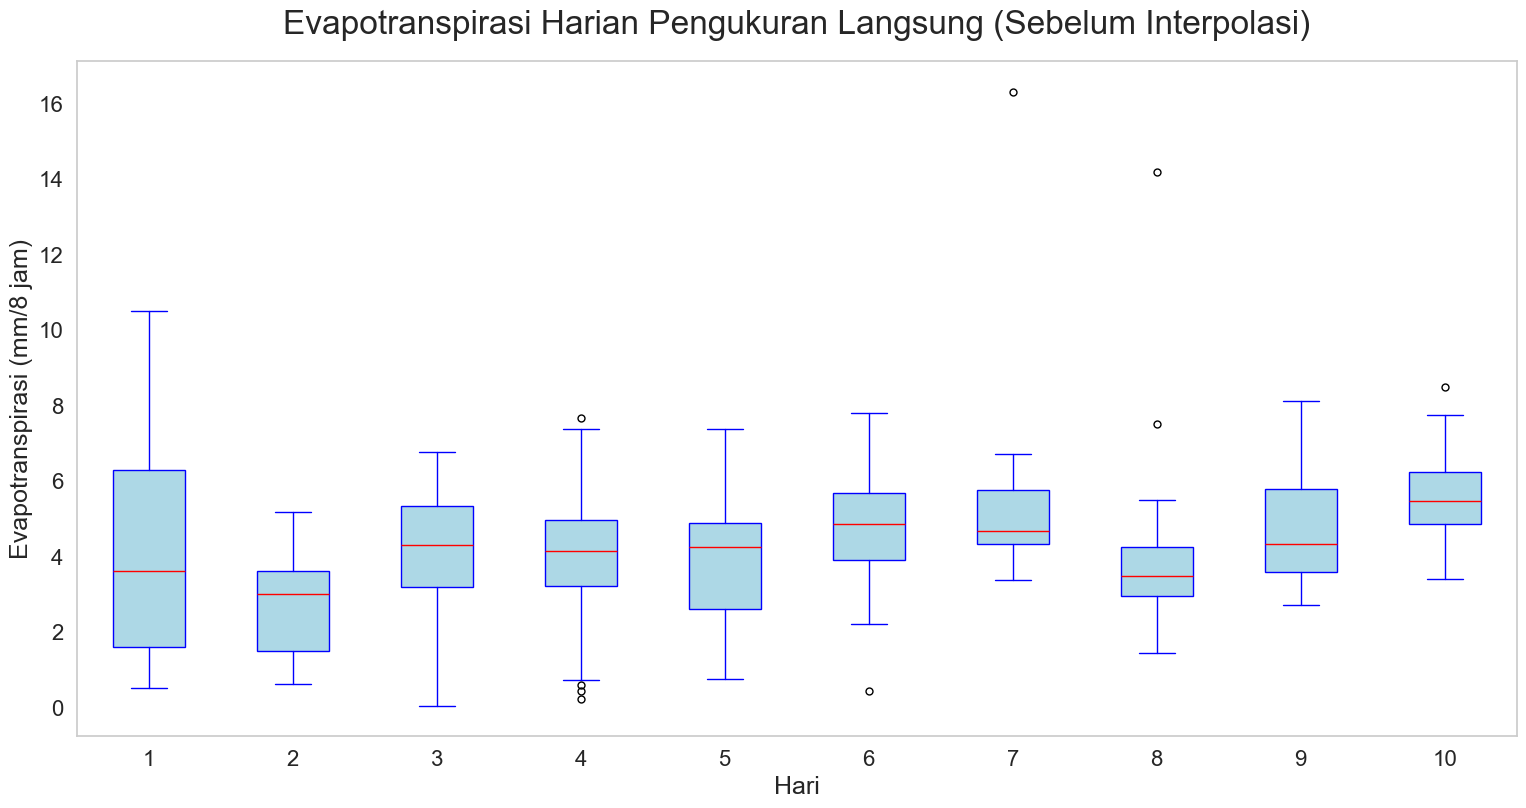

In [1480]:
# Reset index to make 'Num Day' a column again
df_gravimetri_reset = df_gravimetri.reset_index()

# Convert df_gravimetri to long format
data_aktual_long = df_gravimetri_reset.melt(id_vars=['Num Day'], var_name='Day', value_name='Evapotranspirasi')

# Membuat plot boxplot dengan ukuran besar
fig, ax = plt.subplots(figsize=(18, 9))  # Ukuran figure diperbesar
boxplot = data_aktual_long.boxplot(by='Num Day', column='Evapotranspirasi', grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='blue'),
           capprops=dict(color='blue'),
           medianprops=dict(color='red'),
           flierprops=dict(marker='o', color='red', markersize=5),
           ax=ax)

# Tambahkan judul dan label
ax.set_title('Evapotranspirasi Harian Pengukuran Langsung (Sebelum Interpolasi)', fontsize=24, pad=20)
ax.set_xlabel('Hari', fontsize=18)
ax.set_ylabel('Evapotranspirasi (mm/8 jam)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Ubah keterangan sumbu x menjadi angka 1 sampai 10
ax.set_xticklabels(range(1, 11))

plt.suptitle('')

# Tampilkan plot
plt.show()

# Penanganan Outlier

In [1481]:
# Function to detect outliers using IQR
def detect_outliers(df, multiplier=3):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = (df < (Q1 - multiplier * IQR)) | (df > (Q3 + multiplier * IQR))
    return is_outlier

In [1482]:
# Function to handle outliers and fill missing values using IterativeImputer
def handle_outliers_with_iterative(df, max_iterations=100):
    imputer = IterativeImputer(max_iter=10, tol=1e-1000, random_state=0)
    iteration = 0
    best_df = df.copy()
    min_outliers = float('inf')

    while iteration < max_iterations:
        print(f"Iteration {iteration + 1}")
        # Detect outliers
        outliers = detect_outliers(df)
        num_outliers = outliers.sum().sum()

        # If the current iteration has fewer outliers, update the best_df
        if num_outliers < min_outliers:
            min_outliers = num_outliers
            best_df = df.copy()

        # If no outliers are detected, break the loop
        if num_outliers == 0:
            break

        # Replace outliers with NaN
        df[outliers] = np.nan

        # Apply Iterative imputation
        df.iloc[:, :] = imputer.fit_transform(df)

        iteration += 1

    # print(f"Best iteration with {min_outliers} outliers")
    return best_df


In [1483]:
# Method with KNN Imputer
def handle_outliers_with_knn(df, max_iterations=100, n_neighbors=10, tol=1e-4):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    prev_outliers = None

    for iteration in range(max_iterations):
        # print(f"Iteration {iteration + 1}")
        # Detect outliers
        outliers = detect_outliers(df)
        num_outliers = outliers.sum().sum()

        # Break if no more outliers or improvement is too small
        if prev_outliers is not None and abs(prev_outliers - num_outliers) < tol:
            break
        prev_outliers = num_outliers

        # Replace outliers with NaN
        df[outliers] = np.nan

        # Impute missing values using KNN Imputer
        df.iloc[:, :] = imputer.fit_transform(df)

    return df

In [1484]:
df_gravimetri_interpolate = df_gravimetri

In [1485]:
polynomial_pipeline = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
imputer = IterativeImputer(estimator=polynomial_pipeline, max_iter=10, random_state=0)

# Handle outliers and fill missing values
df_gravimetri_interpolate = handle_outliers_with_knn(df_gravimetri_interpolate)

data_hari = [3, 7, 6]
for idx in data_hari:
    df_gravimetri_interpolate.loc[idx] = np.nan
    df_gravimetri_interpolate.iloc[:, :] = imputer.fit_transform(df_gravimetri_interpolate)

d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [1486]:
df_gravimetri_interpolate.to_csv('hasil/ET Aktual Gravimetri Interpolasi.csv', index=True)

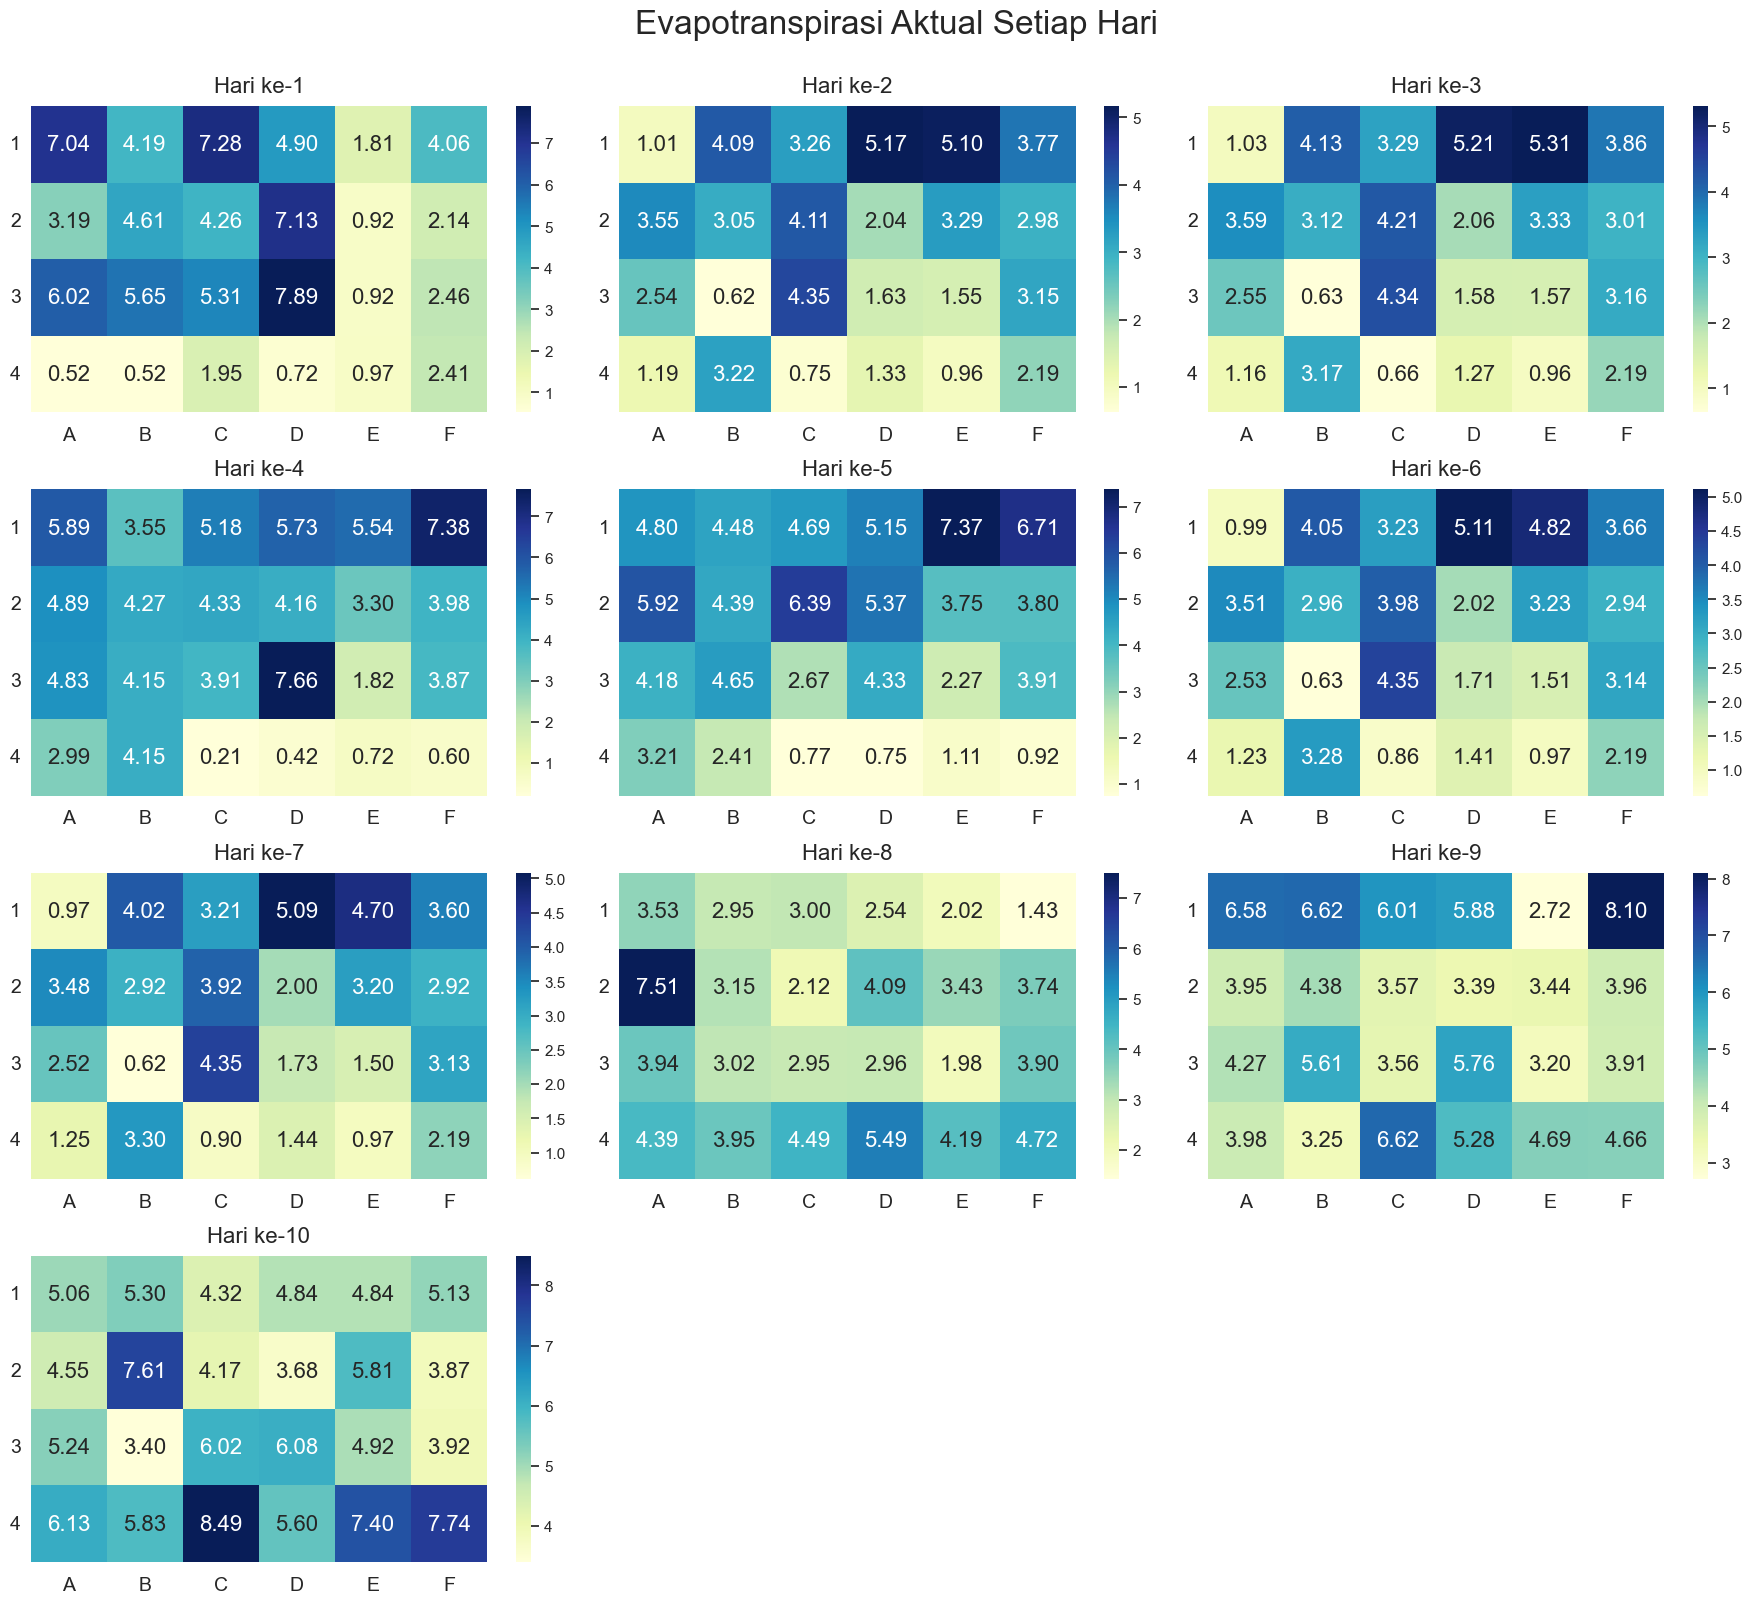

In [1487]:
# Plot heatmaps
fig, axes = plt.subplots(4, 3, figsize=(18, 16))  # 4x3 grid
axes = axes.flatten()

for i, (day, data) in enumerate(df_gravimetri_interpolate.iterrows()):
    # Reshape data untuk heatmap
    day_data = data.values.reshape(4, 6)  # Reshape ke (4x6)
    
    # Plot heatmap
    sns.heatmap(
        day_data, annot=True, fmt=".2f", cmap="YlGnBu",
        xticklabels=[], yticklabels=[],
        annot_kws={"size": 16},  # Perbesar ukuran font nilai data
        ax=axes[i]
    )
    axes[i].set_title(f"Hari ke-{i+1}", fontsize=16, pad=10)

    # Tambahkan label X (A-F) dan Y (1-4)
    for col in range(6):
        axes[i].text(col + 0.5, 4.3, f"{chr(65 + col)}", ha="center", va="center", fontsize=14)
    for row in range(4):
        axes[i].text(-0.2, row + 0.5, f"{row + 1}", ha="center", va="center", fontsize=14)

# Hilangkan subplot kosong jika jumlah hari kurang dari 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Evapotranspirasi Aktual Setiap Hari", fontsize=24, y=1)
plt.tight_layout()
plt.show()

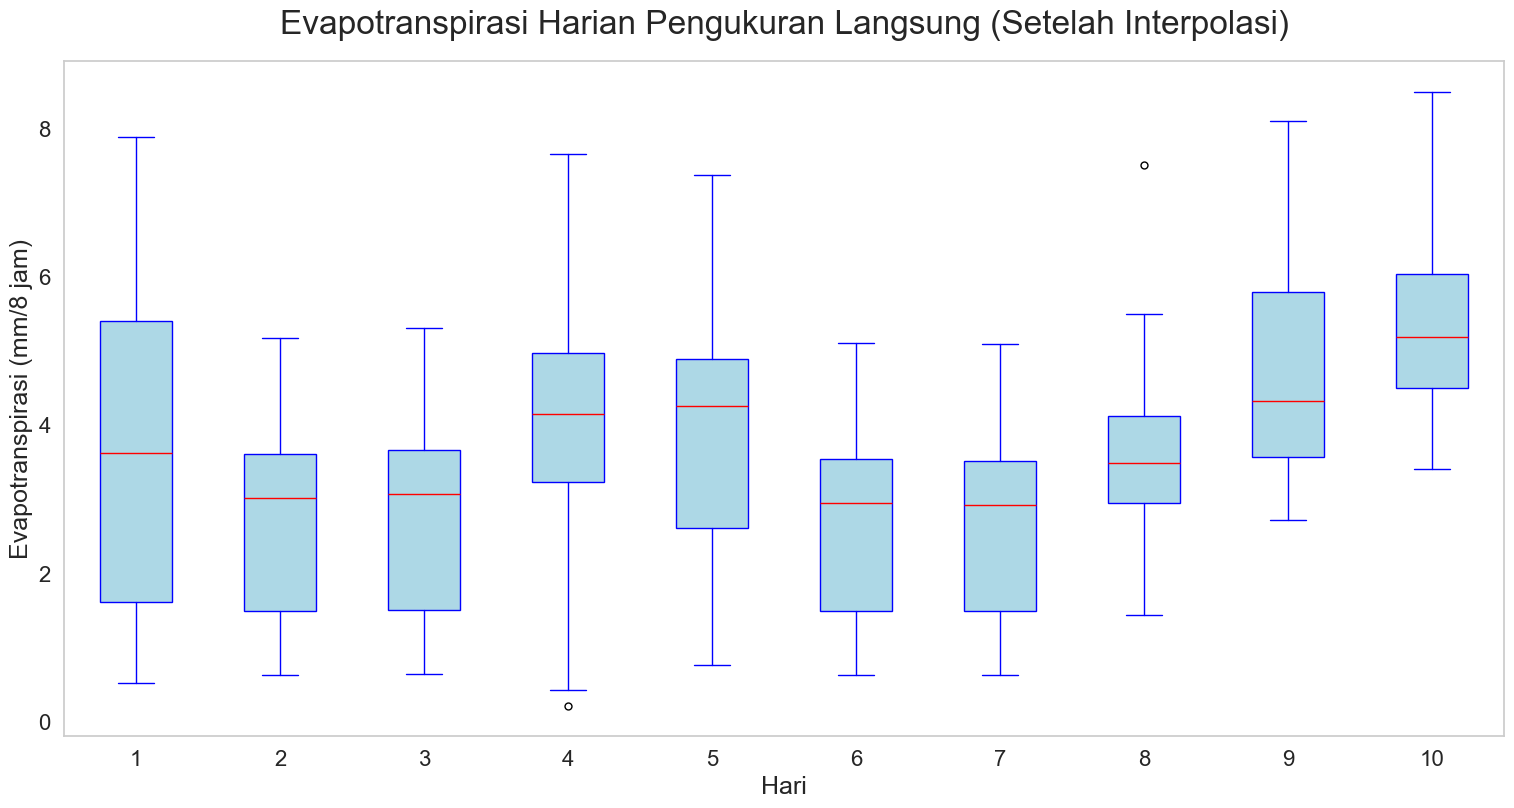

In [1488]:
# Reset index to make 'Num Day' a column again
df_gravimetri_reset = df_gravimetri_interpolate.reset_index()

# Convert df_gravimetri to long format
data_aktual_long = df_gravimetri_reset.melt(id_vars=['Num Day'], var_name='Day', value_name='Evapotranspirasi')

# Membuat plot boxplot dengan ukuran besar
fig, ax = plt.subplots(figsize=(18, 9))
boxplot = data_aktual_long.boxplot(by='Num Day', column='Evapotranspirasi', whis=1.7, grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='blue'),
           capprops=dict(color='blue'),
           medianprops=dict(color='red'),
           flierprops=dict(marker='o', color='red', markersize=5),
           ax=ax)

# Tambahkan judul dan label
ax.set_title('Evapotranspirasi Harian Pengukuran Langsung (Setelah Interpolasi)', fontsize=24, pad=20)
ax.set_xlabel('Hari', fontsize=18)
ax.set_ylabel('Evapotranspirasi (mm/8 jam)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Ubah keterangan sumbu x menjadi angka 1 sampai 10
ax.set_xticklabels(range(1, 11))

plt.suptitle('')

# Tampilkan plot
plt.show()


# Perbandingan Data Aktual dan Estimasi

In [1489]:
df_bc = df_bc.reset_index(drop=True)
df_bc.index = df_bc.index + 1

df_hs = df_hs.reset_index(drop=True)
df_hs.index = df_hs.index + 1

df_pm = df_pm.reset_index(drop=True)
df_pm.index = df_pm.index + 1

In [1490]:
# Define df_gravimetri_analisis
df_gravimetri_analisis = pd.DataFrame(index=df_gravimetri_interpolate.index)

# Menghitung rata-rata harian dari semua tanaman
df_gravimetri_analisis['Average'] = df_gravimetri_interpolate.iloc[:, 0:-1].mean(axis=1)

# Menghitung median untuk setiap hari
df_gravimetri_analisis['Median'] = df_gravimetri_interpolate.iloc[:, 0:-1].median(axis=1)

# Menghitung Standar Deviasi untuk setiap hari
df_gravimetri_analisis['STDEV'] = df_gravimetri_interpolate.iloc[:, 0:-1].std(axis=1)

# Menghitung IQR (Interquartile Range) untuk setiap hari
Q1 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(0.25, axis=1)
Q2 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(0.5, axis=1)
Q3 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(0.75, axis=1)
Q4 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(1, axis=1)

df_gravimetri_analisis['Q1'] = Q1
df_gravimetri_analisis['Q2'] = Q2
df_gravimetri_analisis['Q3'] = Q3
df_gravimetri_analisis['Q4'] = Q4
df_gravimetri_analisis['IQR'] = Q3 - Q1

df_gravimetri_analisis = df_gravimetri_analisis.round(2)
df_gravimetri_analisis.head()

,Average,Median,STDEV,Q1,Q2,Q3,Q4,IQR
Num Day,,,,,,,,
1,3.67,4.06,2.44,1.81,4.06,5.31,7.89,3.50
2,2.73,3.05,1.39,1.63,3.15,3.77,5.17,2.14
3,2.75,3.12,1.43,1.58,3.16,3.86,5.31,2.27
4,4.04,4.15,1.92,3.55,4.15,4.89,7.66,1.34
5,4.05,4.33,1.79,3.21,4.33,5.15,7.37,1.94


In [1491]:
df_gravimetri_analisis.to_csv('hasil/ET Aktual Gravimetri Statistik Deskriptif.csv', index=True)

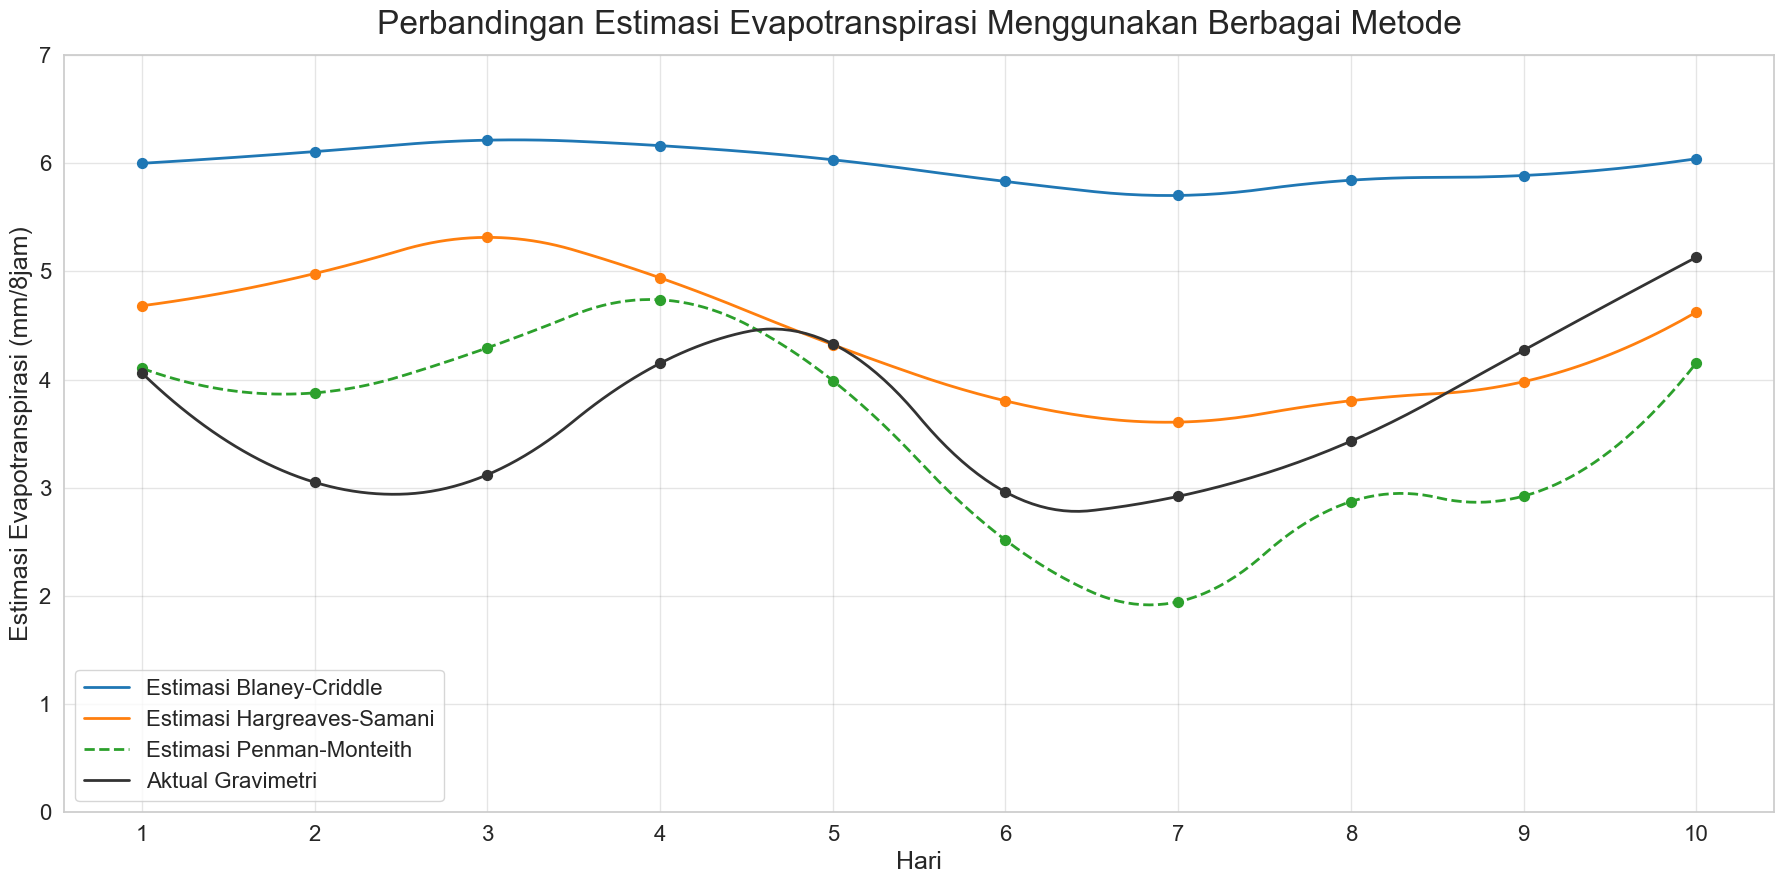

In [1492]:
from scipy.interpolate import make_interp_spline

sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(18, 9))

# Fungsi untuk membuat kurva melengkung dengan spline interpolasi
def smooth_curve(x, y, num_points=200):
    x_new = np.linspace(x.min(), x.max(), num_points)
    spline = make_interp_spline(x, y, k=2)  # k=3 untuk cubic spline
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Plot data Blaney-Criddle
x_bc, y_bc = smooth_curve(df_bc.index, df_bc['ET Total'])
plt.plot(x_bc, y_bc, label='Estimasi Blaney-Criddle', color='#1f77b4', linewidth=2, linestyle='--')
plt.scatter(df_bc.index, df_bc['ET Total'], color='#1f77b4', s=50, zorder=3)

# Plot data Hargreaves-Samani
x_hs, y_hs = smooth_curve(df_hs.index, df_hs['ET Total'])
plt.plot(x_hs, y_hs, label='Estimasi Hargreaves-Samani', color='#ff7f0e', linewidth=2, linestyle='--')
plt.scatter(df_hs.index, df_hs['ET Total'], color='#ff7f0e', s=50, zorder=3)

# Plot data Penman-Monteith
x_pm, y_pm = smooth_curve(df_pm.index, df_pm['ET Total'])
plt.plot(x_pm, y_pm, label='Estimasi Penman-Monteith', color='#2ca02c', linewidth=2, linestyle='--')
plt.scatter(df_pm.index, df_pm['ET Total'], color='#2ca02c', s=50, zorder=3)

# Plot data gravimetri
x_grav, y_grav = smooth_curve(df_gravimetri_analisis.index, df_gravimetri_analisis['Median'])
plt.plot(x_grav, y_grav, label='Aktual Gravimetri', color='#333333', linewidth=2, linestyle='--')
plt.scatter(df_gravimetri_analisis.index, df_gravimetri_analisis['Median'], color='#333333', s=50, zorder=3)

# Judul dan label sumbu
plt.title('Perbandingan Estimasi Evapotranspirasi Menggunakan Berbagai Metode', fontsize=24, pad=15)
plt.xlabel('Hari', fontsize=18)
plt.ylabel('Estimasi Evapotranspirasi (mm/8jam)', fontsize=18)

# Menentukan ticks pada sumbu x dengan interval 1
x_min = min(df_bc.index.min(), df_hs.index.min(), df_pm.index.min(), df_gravimetri_analisis.index.min())
x_max = max(df_bc.index.max(), df_hs.index.max(), df_pm.index.max(), df_gravimetri_analisis.index.max())
plt.xticks(np.arange(x_min, x_max + 1, 1), fontsize=16)  # Rentang 1 untuk label x

plt.yticks(fontsize=16)

# Grid dan legenda
plt.grid(True, linestyle='-', color='gray', alpha=0.2)
plt.legend(fontsize=16, frameon=True, loc='lower left')

# Rentang sumbu y
plt.ylim(0, 7)
plt.tight_layout()

# Tampilkan grafik
plt.show()

# Analisis Parameter

In [1493]:
df_analisis_parameter = df_gravimetri_analisis[['Median']].copy()
df_analisis_parameter.rename(columns={'Median': 'Gravimetri'}, inplace=True)

df_analisis_parameter.loc[:, 'Blaney-Criddle'] = df_bc['ET Total']
df_analisis_parameter.loc[:, 'Hargreaves-Samani'] = df_hs['ET Total']
df_analisis_parameter.loc[:, 'Penman-Monteith'] = df_pm['ET Total']
df_analisis_parameter = df_analisis_parameter.round(2)
df_analisis_parameter

,Gravimetri,Blaney-Criddle,Hargreaves-Samani,Penman-Monteith
Num Day,,,,
1,4.06,6.00,4.68,4.10
2,3.05,6.11,4.98,3.88
3,3.12,6.21,5.31,4.29
4,4.15,6.16,4.94,4.74
5,4.33,6.03,4.32,3.99
6,2.96,5.83,3.80,2.52
7,2.92,5.70,3.61,1.95
8,3.43,5.84,3.80,2.87
9,4.27,5.89,3.98,2.92


In [1494]:
# Fungsi menghitung akurasi
def calculate_akurasi(aktual, estimasi):
  error = np.abs(np.mean(estimasi) - np.mean(aktual)) / np.mean(aktual)
  akurasi = (1 - error) * 100
  return akurasi

In [1495]:
# Fungsi untuk menghitung RMSE
def calculate_rmse(actual, estimates):
    return np.sqrt(mean_squared_error(actual, estimates))

In [1496]:
# Fungsi untuk menghitung MAE
def calculate_mae(actual, estimates):
    return mean_absolute_error(actual, estimates)

In [1497]:
# Fungsi untuk menghitung MBE
def calculate_mbe(actual, estimates):
    return np.mean(estimates - actual)

In [1498]:
# Menghitung Akurasi, RMSE, MAE, dan MBE untuk setiap metode
results = {
    'Metode': ['Blaney-Criddle', 'Hargreaves-Samani', 'Penman-Monteith'],
    'Akurasi': [],
    'RMSE': [],
    'MAE': [],
    'MBE': []
}

# Define the actual values
actual = df_analisis_parameter['Gravimetri']

for column in results['Metode']:
    results['Akurasi'].append(calculate_akurasi(actual, df_analisis_parameter[column]))
    results['RMSE'].append(calculate_rmse(actual, df_analisis_parameter[column]))
    results['MAE'].append(calculate_mae(actual, df_analisis_parameter[column]))
    results['MBE'].append(calculate_mbe(actual, df_analisis_parameter[column]))

# Membuat dataframe dari hasil perhitungan
df_results = pd.DataFrame(results)
df_results = df_results.round(2)
df_results

,Metode,Akurasi,RMSE,MAE,MBE
0,Blaney-Criddle,40.17,2.34,2.24,2.24
1,Hargreaves-Samani,82.31,1.06,0.82,0.66
2,Penman-Monteith,94.63,0.82,0.73,-0.20


In [1499]:
df_results.to_csv('hasil/Metrik Parameter Metode Estimasi ET.csv', index=False)

# Pisah Plot

In [1500]:
df_gravimetri_interpolate.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Num Day,,,,,,,,,,,,,,,,,,,,,
1,7.040000,4.192000,7.28000,4.904889,1.811111,4.055556,3.188889,4.611111,4.260045,7.126531,...,5.312500,7.887500,0.923457,2.459259,0.518519,0.523457,1.948000,0.716000,0.968000,2.408000
2,1.007000,4.095000,3.26300,5.167000,5.103889,3.770556,3.548333,3.048333,4.112959,2.039490,...,4.346250,1.633750,1.545864,3.150802,1.190309,3.219938,0.745000,1.329000,0.965000,2.189000
3,1.031222,4.130488,3.28974,5.205997,5.309693,3.859003,3.587285,3.115357,4.214084,2.064084,...,4.341802,1.584536,1.572573,3.162377,1.164735,3.174798,0.664811,1.273472,0.963757,2.191373
4,5.888000,3.552000,5.18400,5.728000,5.544444,7.377778,4.888889,4.266667,4.334694,4.155102,...,3.912500,7.656250,1.822222,3.866667,2.992593,4.148148,0.208000,0.424000,0.720000,0.600000
5,4.801000,4.481000,4.68900,5.153000,7.372778,6.706111,5.922778,4.389444,6.385816,5.369490,...,2.673125,4.329375,2.273395,3.912901,3.211667,2.409198,0.767000,0.751000,1.113000,0.923000


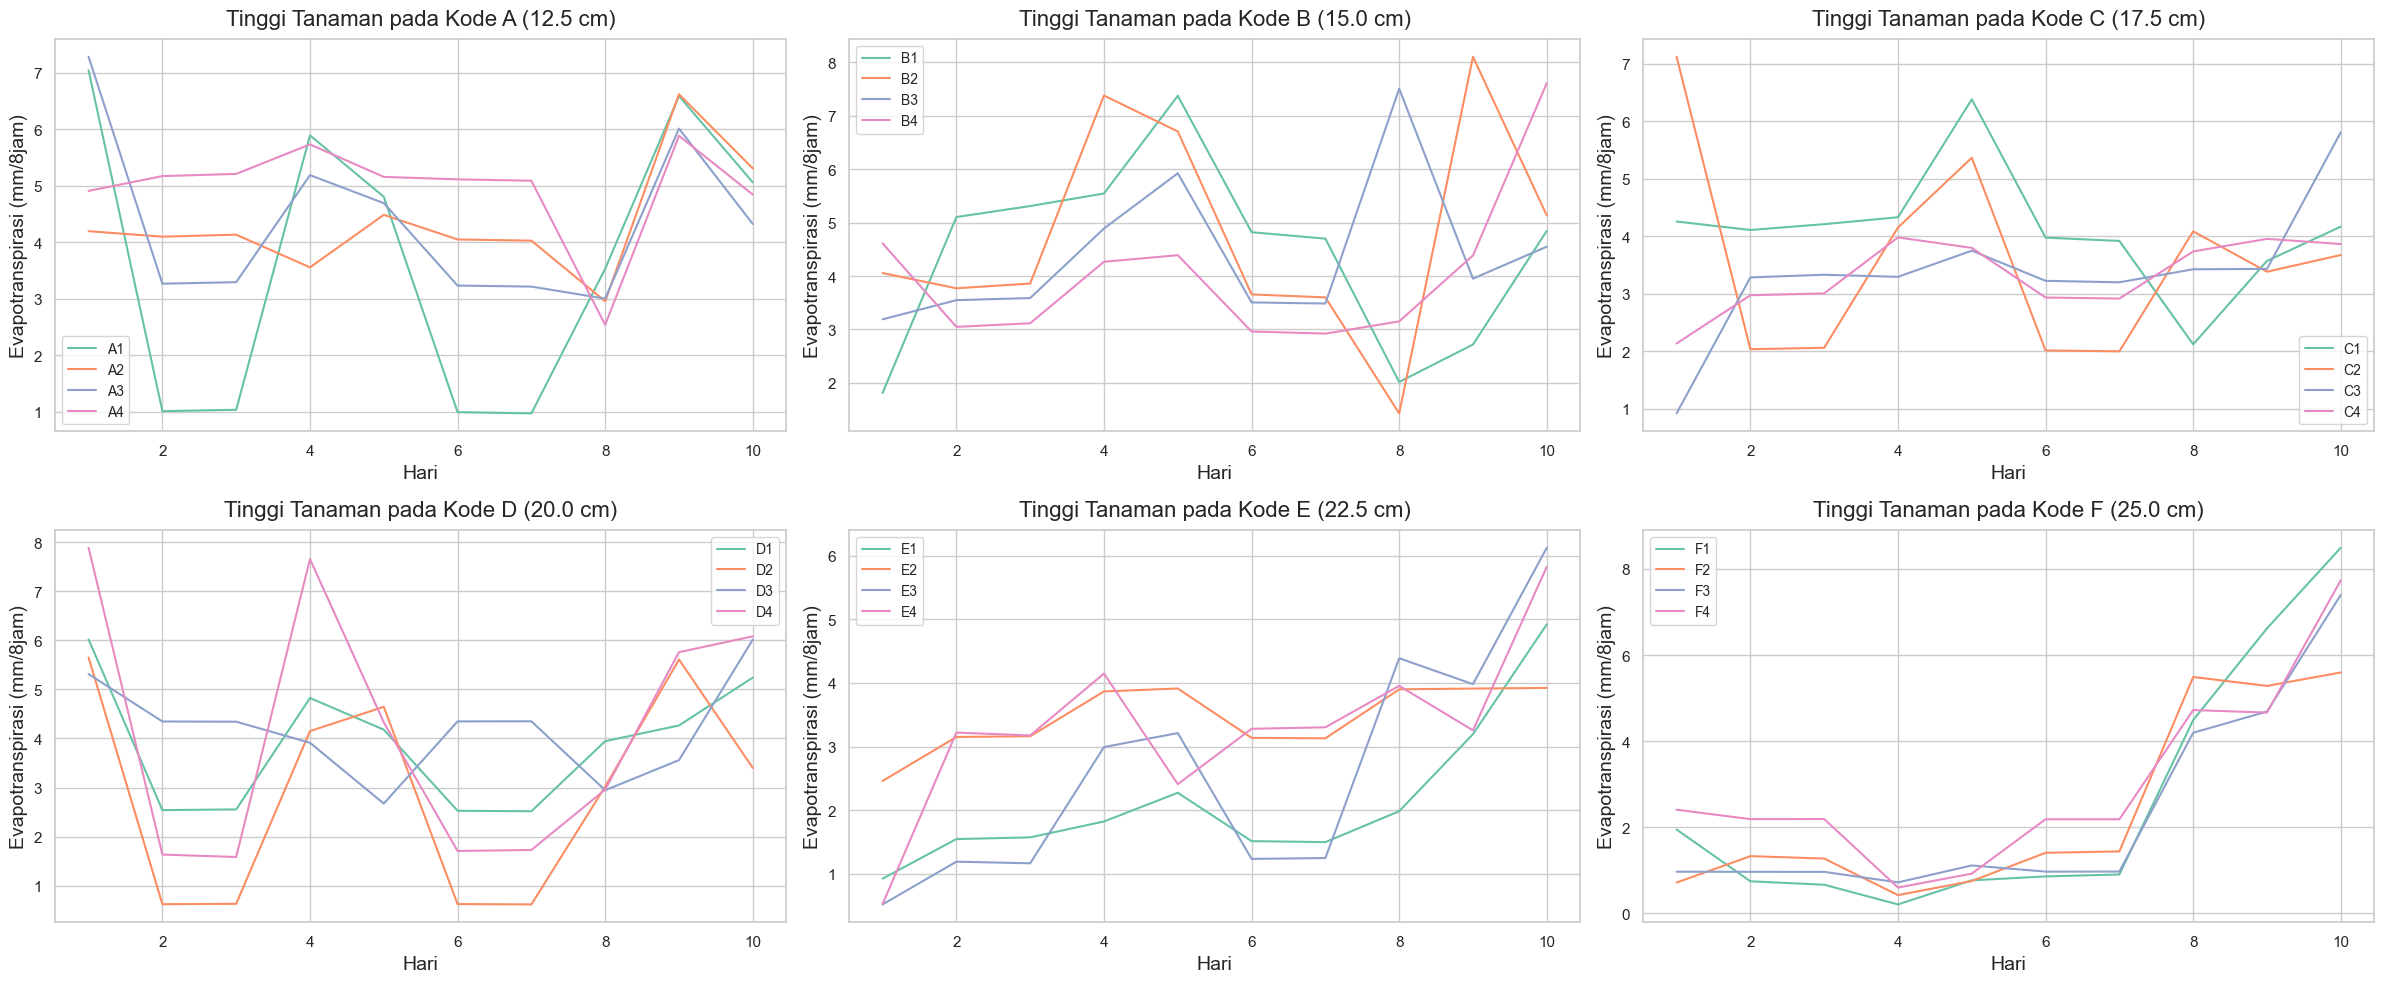

In [1501]:
# Create a single figure with 6 subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 10))
axes = axes.flatten()

for i, (pot, columns) in enumerate(var.pot_groups.items()):
    for col in columns:
        axes[i].plot(df_gravimetri_interpolate.index, df_gravimetri_interpolate[col], label=col)
    
    axes[i].set_title(f'Tinggi Tanaman pada Kode {pot} ({var.sisi_media_tanaman[var.pot_groups[pot][1]][0]} cm)', fontsize=16, pad=10)
    axes[i].set_xlabel('Hari', fontsize=14)
    axes[i].set_ylabel('Evapotranspirasi (mm/8jam)', fontsize=14)
    axes[i].legend(fontsize=10)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# ANOVA

In [1502]:
df_data_anova = pd.read_csv('hasil/Data Anova.csv')
df_data_anova.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah
0,A1,day 05,2.181938,78100.0,25,156.25
1,A2,day 05,3.039563,78100.0,40,156.25
2,A3,day 05,3.915938,78100.0,45,156.25
3,A4,day 05,3.264563,78100.0,60,156.25
4,B1,day 05,3.590562,78100.0,25,225.00


In [1503]:
mean_values = df_gravimetri_interpolate.mean()
df_mean = mean_values.to_frame(name='Evapotranspirasi')
df_mean = df_mean.reset_index(names='Kode')

df_data_anova = df_data_anova.merge(df_mean, left_on="Kode", right_on="Kode", how="left")
df_data_anova.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah,Evapotranspirasi
0,A1,day 05,2.181938,78100.0,25,156.25,3.689017
1,A2,day 05,3.039563,78100.0,40,156.25,4.339172
2,A3,day 05,3.915938,78100.0,45,156.25,4.347380
3,A4,day 05,3.264563,78100.0,60,156.25,4.960864
4,B1,day 05,3.590562,78100.0,25,225.00,4.424119


In [1504]:
print(df_data_anova['Tinggi_Tanaman'].unique())
print(df_data_anova['Luas_Permukaan_Wadah'].unique())
print(df_data_anova['Intensitas_Matahari'].unique())

[25 40 45 60]
[156.25 225.   306.25 400.   506.25 625.  ]
[78100.   68837.5  81381.25 63787.5  64418.75 41850.   72318.75 46100.
 49925.   65481.25]


In [1505]:
model = ols('Evapotranspirasi ~ C(Tinggi_Tanaman) + C(Luas_Permukaan_Wadah)', data=df_data_anova).fit()
anova = sm.stats.anova_lm(model, typ=3)
print("Tabel Anova Hubungan Tinggi dan Luas Permukaan Wadah Terhadap Evapotranspirasi")
anova['Variabel'] = anova.index
anova

Tabel Anova Hubungan Tinggi dan Luas Permukaan Wadah Terhadap Evapotranspirasi


,sum_sq,df,F,PR(>F),Variabel
Intercept,471.799826,1.0,3027.815550,9.424672e-135,Intercept
C(Tinggi_Tanaman),3.665061,3.0,7.840280,5.265337e-05,C(Tinggi_Tanaman)
C(Luas_Permukaan_Wadah),113.947836,5.0,146.253988,1.684894e-69,C(Luas_Permukaan_Wadah)
Residual,35.994848,231.0,NaN,NaN,Residual


In [1506]:
anova.to_csv('hasil/Anova Evapotranspirasi.csv', index=True)

In [1507]:
model_interaksi = ols('Evapotranspirasi ~ C(Tinggi_Tanaman) * C(Luas_Permukaan_Wadah)', data=df_data_anova).fit()
anova_interaksi = sm.stats.anova_lm(model_interaksi, typ=3)
anova_interaksi


,sum_sq,df,F,PR(>F)
Intercept,1.360885e+02,1.0,5.563678e+30,0.0
C(Tinggi_Tanaman),8.091665e+00,3.0,1.102700e+29,0.0
C(Luas_Permukaan_Wadah),4.137131e+01,5.0,3.382750e+29,0.0
C(Tinggi_Tanaman):C(Luas_Permukaan_Wadah),3.599485e+01,15.0,9.810467e+28,0.0
Residual,5.283396e-27,216.0,NaN,NaN


In [1508]:
anova_interaksi.to_csv('hasil/Anova interaksi Evapotranspirasi.csv', index=True)

C:\Users\RafiAchmadfr\AppData\Local\Temp\ipykernel_23608\2605816038.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x="Tinggi_Tanaman", y="Evapotranspirasi", hue="Luas_Permukaan_Wadah", data=df_data_anova, ci="sd", markers=["o", "s", "D", "^", "v", "p", "*", "X", "d", "P"])


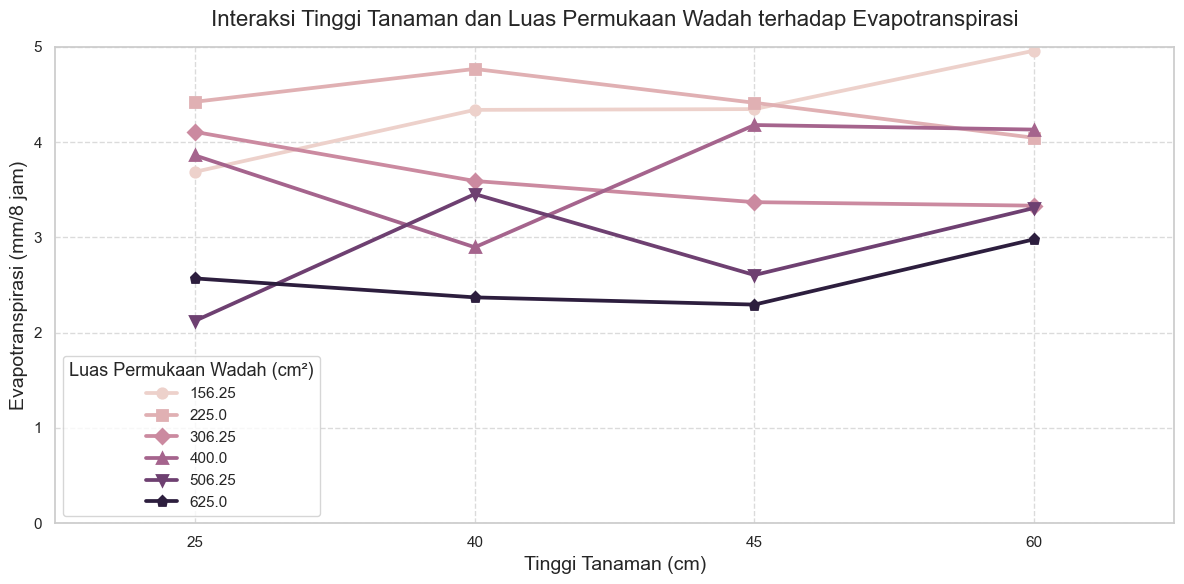

In [1509]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot interaksi
plt.figure(figsize=(12, 6))
sns.pointplot(x="Tinggi_Tanaman", y="Evapotranspirasi", hue="Luas_Permukaan_Wadah", data=df_data_anova, ci="sd", markers=["o", "s", "D", "^", "v", "p", "*", "X", "d", "P"])
plt.title("Interaksi Tinggi Tanaman dan Luas Permukaan Wadah terhadap Evapotranspirasi", fontsize=16, pad=15)
plt.xlabel("Tinggi Tanaman (cm)", fontsize=14)
plt.ylabel("Evapotranspirasi (mm/8 jam)", fontsize=14)
plt.legend(title="Luas Permukaan Wadah (cm²)", title_fontsize='13', fontsize='11', loc='lower left')
plt.ylim(0, 5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [1510]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df_data_anova['Evapotranspirasi'],
    groups=df_data_anova['Tinggi_Tanaman'].astype(str) + ':' + df_data_anova['Luas_Permukaan_Wadah'].astype(str),
    alpha=0.05
)
# Menampilkan tabel hasil Tukey HSD
print(tukey.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reject
---------------------------------------------------------
25:156.25  25:225.0   0.7351   0.0  0.7351  0.7351   True
25:156.25 25:306.25    0.419   0.0   0.419   0.419   True
25:156.25  25:400.0    0.172   0.0   0.172   0.172   True
25:156.25 25:506.25  -1.5641   0.0 -1.5641 -1.5641   True
25:156.25  25:625.0   -1.119   0.0  -1.119  -1.119   True
25:156.25 40:156.25   0.6502   0.0  0.6502  0.6502   True
25:156.25  40:225.0   1.0801   0.0  1.0801  1.0801   True
25:156.25 40:306.25  -0.0962   0.0 -0.0962 -0.0962   True
25:156.25  40:400.0  -0.7921   0.0 -0.7921 -0.7921   True
25:156.25 40:506.25  -0.2338   0.0 -0.2338 -0.2338   True
25:156.25  40:625.0  -1.3179   0.0 -1.3179 -1.3179   True
25:156.25 45:156.25   0.6584   0.0  0.6584  0.6584   True
25:156.25  45:225.0   0.7244   0.0  0.7244  0.7244   True
25:156.25 45:306.25  -0.3184   0.0 -0.3184 -0.3184   True
25:156.25  45:

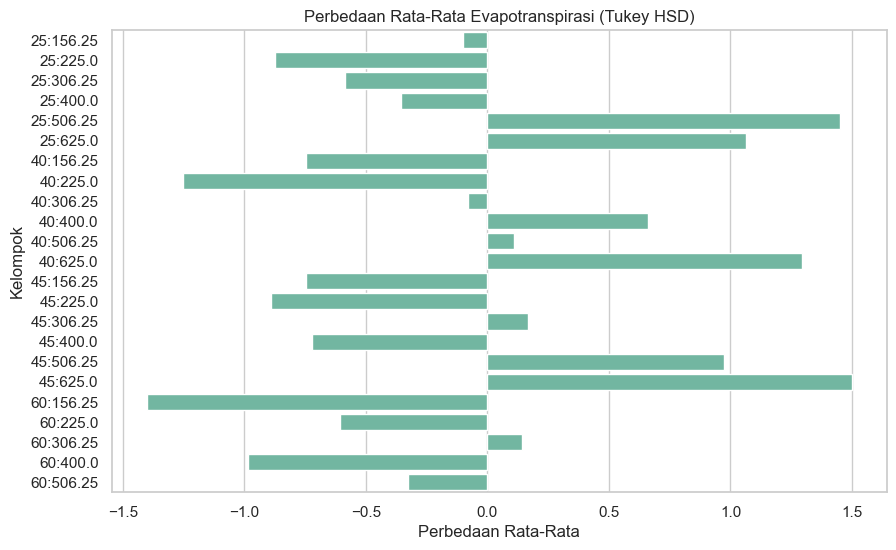

In [1511]:
# Contoh visualisasi hasil Tukey
tukey_summary = tukey.summary()
tukey_results_df = pd.DataFrame(data=tukey_summary.data[1:], columns=tukey_summary.data[0])

plt.figure(figsize=(10, 6))
sns.barplot(x='meandiff', y='group1', data=tukey_results_df, errorbar=None)
plt.title('Perbedaan Rata-Rata Evapotranspirasi (Tukey HSD)')
plt.xlabel('Perbedaan Rata-Rata')
plt.ylabel('Kelompok')
plt.show()